Выпускная квалификационная работа Бутаковой Натальи Валерьевны.
Тема исследования: Прогнозирование конечных свойств новых материалов (композиционных материалов).
Часть 2

Во вторую часть выделена работа над нейронной сетью по прогнозированию свойства композитов Соотношения матрица-наполнитель на основе других характеристик материалов, представленных в датасете.
Здесь уже не будем дублировать анализ данных и подробно останавливаться на подготовке данных - воспользуемся результатами ранее проведенной работы (см. часть 1).

Импорт библиотек

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [48]:
import tensorflow.keras as keras
#import keras as keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD

Загружаем исходные данные - датасет со свойствами композитов.
Датасет представлен 2мя таблицами в формате Excel , требующих объединения INNER.
X_bp.xlsx - характеристики бальтопластика
X_nup.xlsx характеристики углепластика

In [3]:
#Указываем путь к файламс данными
data_path = '../Data/'

In [4]:
#Загружаем данные из первого файла, смотрим размерность и названия столбцов
df_bp = pd.read_excel(data_path + 'X_bp.xlsx', index_col=0)
#Загружаем данные из второго файла, смотрим размерность и названия столбцов
df_nup = pd.read_excel(data_path + 'X_nup.xlsx', index_col=0)
#Объединяем датасеты в один, по inner, как указано в условиях задачи
df = df_bp.merge(df_nup, left_index = True, right_index = True, how = 'inner')
#Выведем размерность итогового датасета, и так же посмотрим первые 5 строк
df.shape

(1023, 13)

In [8]:
df.head()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857143,2030.0,738.736842,30.00,22.267857,100.000000,210.0,70.0,3000.0,220.0,0,4.0,57.0
1,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0,0,4.0,60.0
2,1.857143,2030.0,738.736842,49.90,33.000000,284.615385,210.0,70.0,3000.0,220.0,0,4.0,70.0
3,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0,0,5.0,47.0
4,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,57.0


После объединения в итоговом датасете имеем 1023 объекта с 13ю признаками, 1 из которых являются целевым в данном случае.

In [11]:
#Смотрим описательную статистику:
#count - количество значений
#mean - среднее значение
#std - стандартное отклонение
#min - минимум
#25% - верхнее значение первого квартиля
#50% - медиана
#75% - верхнее значение третьего квартиля
#max - максимум
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,1023.0,2.930366,0.913222,0.389403,2.317887,2.906878,3.552660,5.591742
"Плотность, кг/м3",1023.0,1975.734888,73.729231,1731.764635,1924.155467,1977.621657,2021.374375,2207.773481
"модуль упругости, ГПа",1023.0,739.923233,330.231581,2.436909,500.047452,739.664328,961.812526,1911.536477
"Количество отвердителя, м.%",1023.0,110.570769,28.295911,17.740275,92.443497,110.564840,129.730366,198.953207
"Содержание эпоксидных групп,%_2",1023.0,22.244390,2.406301,14.254985,20.608034,22.230744,23.961934,33.000000
"Температура вспышки, С_2",1023.0,285.882151,40.943260,100.000000,259.066528,285.896812,313.002106,413.273418
"Поверхностная плотность, г/м2",1023.0,482.731833,281.314690,0.603740,266.816645,451.864365,693.225017,1399.542362
"Модуль упругости при растяжении, ГПа",1023.0,73.328571,3.118983,64.054061,71.245018,73.268805,75.356612,82.682051
"Прочность при растяжении, МПа",1023.0,2466.922843,485.628006,1036.856605,2135.850448,2459.524526,2767.193119,3848.436732
"Потребление смолы, г/м2",1023.0,218.423144,59.735931,33.803026,179.627520,219.198882,257.481724,414.590628


Предобработка данных

In [9]:
#На этот раз сначала разделяем данные на входные признаки и целевой параметр, а потом уже будем масштабировать
#Входные данные
X = df.drop(['Соотношение матрица-наполнитель'], axis=1)
#Целевые признаки
y = df[['Соотношение матрица-наполнитель']]

Т.к. имеем дело с задачей регрессии, и признаки имеют значения в разных диапазонах, произведем нормализацию (масштабирование) данных с помощью метода MinMaxScaler. Одна выполнять это преобразование будем только с входными параметрами.

In [12]:
#Нормализуем данные с помощью MinMaxScaler
min_max_scaler = MinMaxScaler()
X_norm = pd.DataFrame(min_max_scaler.fit_transform(X), columns = X.columns, index=X.index)

In [14]:
#Посмотрим результат
X_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
"Плотность, кг/м3",1023.0,0.512533,0.154890,0.0,0.404175,0.516497,0.608413,1.0
"модуль упругости, ГПа",1023.0,0.386301,0.172978,0.0,0.260652,0.386165,0.502528,1.0
"Количество отвердителя, м.%",1023.0,0.512273,0.156147,0.0,0.412240,0.512240,0.618003,1.0
"Содержание эпоксидных групп,%_2",1023.0,0.426215,0.128370,0.0,0.338919,0.425487,0.517842,1.0
"Температура вспышки, С_2",1023.0,0.593354,0.130695,0.0,0.507756,0.593401,0.679924,1.0
"Поверхностная плотность, г/м2",1023.0,0.344638,0.201092,0.0,0.190296,0.322574,0.495105,1.0
"Модуль упругости при растяжении, ГПа",1023.0,0.497880,0.167435,0.0,0.386030,0.494672,0.606751,1.0
"Прочность при растяжении, МПа",1023.0,0.508634,0.172724,0.0,0.390881,0.506003,0.615432,1.0
"Потребление смолы, г/м2",1023.0,0.484838,0.156875,0.0,0.382955,0.486875,0.587411,1.0
"Угол нашивки, град",1023.0,0.491691,0.500175,0.0,0.000000,0.000000,1.000000,1.0


Видим, что теперь значения каждого признака лежат в диапазоне от 0 до 1.

In [15]:
#Делим данные на обучающую и тестовую выборку в соотношении 70% и 30% соответственно
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=1)

In [16]:
#Сделаем процедуру для распечатки метрик
def print_metrics(y_test_values, y_pred_values):
    MSE = metrics.mean_squared_error(y_test_values, y_pred_values).round(3)
    MAE = metrics.mean_absolute_error(y_test_values, y_pred_values)
    CoefDet = metrics.r2_score(y_test_values, y_pred_values).round(3)
    print('Средняя квадратичная ошибка MSE=', MSE)
    print('Средняя абсолютная ошибка MAE=', MAE.round(3))
    print('Коэффициент детерминации R2=', CoefDet)
    print('Точность модели (%)', ((1-MAE/np.mean(y_test_values.values))*100).round(3))

In [17]:
#Напишем еще функции для отрисовки результатов прогнозирования 
#Функция построения графика оригинального и предсказанного значения у
def plot_act_pred(original_y, predicted_y):    
    plt.figure(figsize=(10,5))
    plt.title('Тестовые и прогнозируемые значения', size=12)
    plt.plot(range(len(original_y)), original_y, color='green', label = 'Тестовые значения')
    plt.plot(range(len(predicted_y)), predicted_y, color='red', label = 'Прогнозные значения')
    plt.legend(loc='best')
    plt.show()

#Функция построения точечного графика оригинального и предсказанного значения у   
def scatter_act_pred(original_y, predicted_y):
    plt.figure(figsize=(10,5))
    plt.title('Рассеяние тестовых и прогнозируемых значений', size=15)
    plt.scatter(original_y, predicted_y)
    plt.xlabel('Тестовые значения', size=12)
    plt.ylabel('Прогнозируемые значения', size=12)
    plt.show()
    
#Функция построения точечных графиков оригинального и предсказанного значения у от х по каждому столбцу
def scatter_by_col(original_X, original_y, predicted_y):
    for col in original_X.columns:
        plt.title('Синий - оригинальные значения, оранжевый - прогноз', size=12)
        plt.scatter(original_X[col], original_y, color='blue')
        plt.scatter(original_X[col], predicted_y, color='orange', marker='x')
        plt.xlabel(col, size=12)
        plt.ylabel(original_y.columns[0] , size=12)    
        plt.show()

10/10 [==============================] - 0s 1ms/step
Средняя квадратичная ошибка MSE= 0.864
Средняя абсолютная ошибка MAE= 0.744
Коэффициент детерминации R2= -0.004
Точность модели (%) 74.646


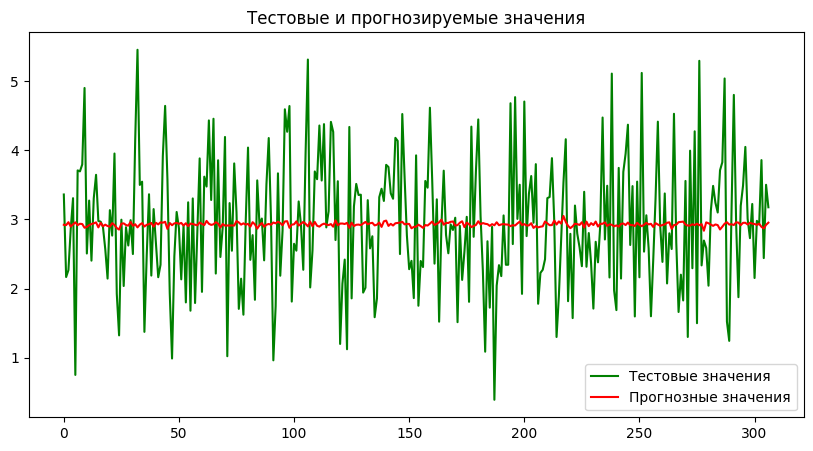

In [45]:
#Вариант 1
def base_model():
    model = Sequential()
    #model.add(Input(shape=12))
    model.add(Dense(8, input_dim=12, activation='tanh')) # скрытый полносвязный слой 1 input_dim=12
    model.add(Dense(8, activation='tanh')) # скрытый полносвязный слой 2
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear')) # выходной слой
    sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    model.compile(loss='mse', optimizer='sgd')
    #model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy']) 
    return model

#Создаем НС и обучаем её
model = base_model()
history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.1) 

#Предсказываем значения
y_pred = model.predict(X_test)

#Печатаем метрики и график
print_metrics(y_test, y_pred)
plot_act_pred(y_test, y_pred)

10/10 [==============================] - 0s 1ms/step
Средняя квадратичная ошибка MSE= 0.859
Средняя абсолютная ошибка MAE= 0.743
Коэффициент детерминации R2= 0.002
Точность модели (%) 74.68


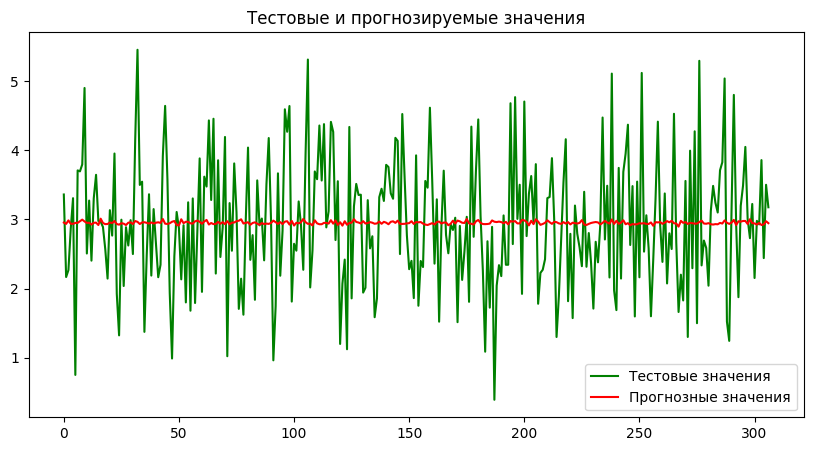

In [50]:
#Вариант 2
def base_model():
    model = Sequential()
    model.add(Input(shape=12))
    model.add(Dense(8, activation='relu')) # скрытый полносвязный слой 1 input_dim=12
    model.add(Dense(16, activation='relu')) # скрытый полносвязный слой 2
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear')) # выходной слой
    sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    model.compile(loss='mse', optimizer='sgd')
    #model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy']) 
    return model

#Создаем НС и обучаем её
model = base_model()
history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.1) 

#Предсказываем значения
y_pred = model.predict(X_test)

#Печатаем метрики и график
print_metrics(y_test, y_pred)
plot_act_pred(y_test, y_pred)

Наконец получился R2 больше 1. Однако остается проблема малого диапазона предсказываемых значений. По сути модель выдает только значения, лежащие около среднего значения.

In [51]:
y_pred_df = pd.DataFrame(y_pred, columns = ['Соотношение матрица-наполнитель'])
y_pred_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,307.0,2.951482,0.021218,2.895802,2.935851,2.949304,2.964764,3.010711


In [30]:
y_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,307.0,2.935234,0.929218,0.389403,2.28667,2.913953,3.546963,5.455566


In [31]:
y_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,716.0,2.928278,0.906926,0.463342,2.337474,2.906517,3.560941,5.591742
